In [ ]:
## 计算基因在每个细胞中的连通重要性

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import networkx as nx
import matplotlib.pyplot as plt
import os

In [2]:
'''读取背景网络'''
def openPPI(filename):
    '''
        打开PPI
        文件格式 gene1_name gene1_id gene2_name gene2_id
        返回值：网络[节点是gene name]
    '''
    G = nx.Graph()
    a=open(filename,"r")
    next(a)

    for i in a:
        n=i.strip().split("\t")
        G.add_edge(n[0],n[3])
        G.add_node(n[0])
        G.add_node(n[3])
    a.close()
    return G

G = openPPI(r"E:\00_CeSOP\data\network(process_id).txt")

In [3]:
# 计算最大连通分支
def Lcc(G,genename):
    '''
        输入图网络和一个列表，计算最大连通分支lcc
        G：图，这里图中的节点是基因name
        genename：用于计算lcc的genename列表
    '''

    g = nx.subgraph(G,genename)
    if len(genename)==0:
        largest = 0
        l = []
        return l,largest
    else:
        try:
            l = max(nx.connected_components(g),key=len)  #如果随机选取的gene没有连通分支的话，会报错，添加判断条件
            largest = len(l)     #最大联通分支
        except ValueError as e:
            l = genename[0]    # 假设genename列表中的第一个基因为最大连通分支
            largest = 1        #设置最大联通分支数为1
        return list(l),largest

In [86]:
import networkx as nx
import matplotlib.pyplot as plt

# 计算最大连通分支的大小
# def max_connected_component_size(G,nodes):
#     '''
#     
#     :param G: 背景网络
#     :param nodes: 
#     :return: 
#     '''
#     if len(nodes) == 0:
#          return 0
#     g = nx.subgraph(G,nodes)
#     if g.number_of_nodes() == 0:
#         return 0
#     else:
#         return max(len(c) for c in nx.connected_components(g))

# 计算最大连通分支
def Lcc(G,nodes):
    '''
        输入图网络和一个列表，计算最大连通分支lcc
        如果空节点集合，返回0；子图不联通，返回1；否则返回最大连通分支
        G：图，这里图中的节点是基因name
        genename：用于计算lcc的genename列表
    '''

    g = nx.subgraph(G,nodes)
    if len(nodes)==0:
        largest = 0
    else:
        try:
            l = max(nx.connected_components(g),key=len)  #如果随机选取的gene没有连通分支的话，会报错，添加判断条件
            largest = len(l)     #最大联通分支
        except ValueError as e:
            l = nodes[0]    # 假设genename列表中的第一个基因为最大连通分支
            largest = 1        #设置最大联通分支数为1
    return largest
    
# 计算节点重要性
def nodeImportance(G,nodes):
    '''
    如果一个节点的删除导致了连通分支（或连通组件）的显著分裂，那么这个节点可以被视为一个关键节点或割点（articulation point）
    :param G:
    :return: 节点重要性字典
    '''
    
    original_max_size = Lcc(G,nodes)
    # 计算节点的重要程度
    node_importance = {}
    for node in nodes:
        # 删除节点后，重新计算lcc
        # 使用列表推导式创建新列表，不包含要移除的元素
        new_nodes = [element for element in nodes if element != node]
        new_max_size = Lcc(G,new_nodes)
        node_importance[node] = original_max_size - new_max_size
    return node_importance


In [46]:
# 读取asthma gwas数据中所有核心基因
trait = pd.read_csv(r"E:\0_单细胞1\data\poly_posterior_prior_gene_new\29_new.txt",sep = "\t")
trait_coregene = list(pd.read_csv(r"E:\0_单细胞1\data\gene set\29_coregene.txt",sep = "\t",header= None)[0])
trait_core = trait[trait["gene name"].isin(trait_coregene)]
##  连通分支（核心）的子图
l_connected_core,lcc = Lcc(G,trait_coregene)

annData = sc.read_h5ad(r"E:\00_CeSOP\data\TS_FACS\TS_Liver.h5ad")
sc_gene = list(annData.var.index)

In [119]:
node_importance_asthma = nodeImportance(G,list(set(sc_gene)&set(l_connected_core)))
node_importance_asthma_df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in node_importance_asthma.items()])).T

In [120]:
node_importance_asthma_df

,0
PARD3B,1
BCL3,1
TGFBR1,3
RUNX3,1
CD247,1
LYN,4
STAT6,17
RREB1,1
CXCR4,1
SMAD7,1


In [103]:
# 读取TS FACS单细胞数据
annData = sc.read_h5ad(r"E:\00_CeSOP\data\TS_FACS\TS_Liver.h5ad")
sc_gene = list(annData.var.index)

# 每个细胞有表达的核心基因的节点重要性
node_importance_df = pd.DataFrame()
# 随机抽取相关组织中的100个细胞 
random_cells = np.random.choice(annData.obs_names, size=1000, replace=False)
for cell in random_cells:
    # 获取每个细胞的基因表达数据
    cell_data = annData[cell].X.toarray().flatten()   
    # 获取细胞有表达的基因
    expressed_genes = annData.var_names[cell_data > 0]  
    # 获取细胞有表达的asthma核心基因
    expressed_asthma_core_genes = list(set(expressed_genes) & set(l_connected_core))
    # 细胞有表达的asthma核心基因形成的子图
    # g = nx.subgraph(G,expressed_asthma_core_genes)
    # 子图中每个节点的重要性
    # print(expressed_asthma_core_genes)
    node_importance = nodeImportance(G,expressed_asthma_core_genes)
    df_expressed_genes = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in node_importance.items()])).T
    
    node_importance_df = pd.concat([node_importance_df,df_expressed_genes],axis = 1)
node_importance_df.columns = random_cells  
# 将 DataFrame 中的 NaN 值替换为 0
node_importance_df.fillna(0, inplace=True)

['RBPJ', 'ETS1', 'BCL3', 'RUNX3', 'PTPRC', 'NCOR2', 'SMAD7', 'SMAD3', 'CXCR4', 'RUNX1', 'IL2RA', 'PRKCH', 'TBL1XR1', 'NFKBIA', 'RCOR1', 'AHR', 'SMARCE1']
['IL4R', 'TGFBR1', 'RUNX3', 'CD247', 'STAT6', 'CXCR4', 'IL2RA', 'PTPRC', 'NFKBIA']
['IL4R', 'CBLB', 'PTPRC', 'LYN', 'RUNX1', 'CXCR4', 'COG6', 'NFKBIA', 'RCOR1', 'AHR', 'SMARCE1', 'IL21R']
['IL4R', 'NEK6', 'BCL3', 'PTPRC', 'RUNX1', 'TBL1XR1', 'NFKBIA', 'NCOA3', 'AHR']
['NEK6', 'RBPJ', 'RUNX3', 'PTPRC', 'NCOR2', 'LYN', 'RREB1', 'SMAD3', 'CXCR4', 'RUNX1', 'SMAD7', 'TBL1XR1', 'NFKBIA', 'AHR']
['LYN', 'CXCR4', 'SMIM20', 'PTPRC', 'NFKBIA']
['NEK6', 'ETS1', 'RBPJ', 'STIM2', 'PLCB1', 'TBL1XR1', 'NFKBIA', 'SMARCE1']
['ETS1', 'CBLB', 'BCL3', 'CXCR4', 'PTPRC']
['IL4R', 'NEK6', 'RBPJ', 'BCL3', 'RUNX3', 'PTPRC', 'NCOR2', 'LYN', 'STAT6', 'RREB1', 'CXCR4', 'RUNX1', 'NCOA3', 'TBL1XR1', 'NFKBIA', 'RCOR1', 'AHR', 'SMARCE1']
['RBPJ', 'BCL3', 'STAT6', 'RREB1', 'STIM2', 'CEBPA', 'COG6']
['IL4R', 'BCL3', 'RUNX3', 'LYN', 'RREB1', 'RUNX1', 'CXCR4', 'NCOA3', 

In [ ]:
### 根据细胞平均水平构造一个基因之间的相互作用

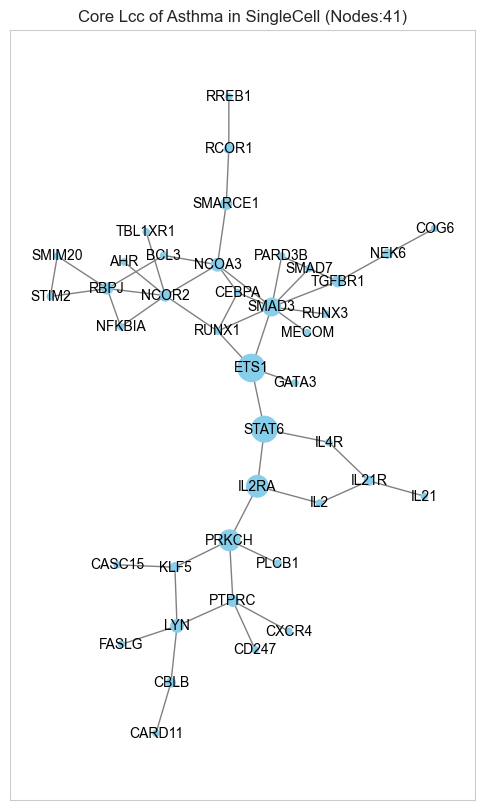

In [121]:
## 可视化最大连通分支,节点大小表示度中心性
def viewNx1(nodes):
    '''

    :param g: 子图
    :param flag: 核心还是外围
    :return: 可视化结果
    '''

    node_importance = nodeImportance(G,nodes)
    g = nx.subgraph(G,nodes)
    # 根据重要程度设置节点大小
    node_sizes = [node_importance[node] * 20 for node in g.nodes()]

    # 连通分支（核心）的子图可视化
    options = {
        'node_color': 'skyblue',
        # 'width': 2,
        'font_size': 10,
        'font_color': 'black',
        # 设置边的属性
        'edge_color' :'grey',
        }
    # 使用Kamada-Kawai布局算法
    pos = nx.kamada_kawai_layout(g)
    plt.figure(figsize=(6, 10))  # 增加图形大小以减少重叠
    # 绘制节点和边
    nx.draw_networkx(
        g,pos,node_size=node_sizes,**options)
    node_num = len(g.nodes)
    plt.title(f"Core Lcc of Asthma in SingleCell (Nodes:{node_num})")
    plt.grid(False)
    plt.show()

# viewNx1(expressed_asthma_core_genes)
viewNx1(list(set(sc_gene)&set(l_connected_core)))

In [106]:
# 读取TS FACS单细胞数据
annData1 = sc.read_h5ad(r"E:\00_CeSOP\data\TS_FACS\TS_Lung.h5ad")
sc_gene1 = list(annData1.var.index)

# 每个细胞有表达的核心基因的节点重要性
node_importance_df1 = pd.DataFrame()
# 随机抽取相关组织中的100个细胞 
random_cells1 = np.random.choice(annData1.obs_names, size=1000, replace=False)
for cell in random_cells1:
    # 获取每个细胞的基因表达数据
    cell_data = annData1[cell].X.toarray().flatten()   
    # 获取细胞有表达的基因
    expressed_genes = annData1.var_names[cell_data > 0]  
    # 获取细胞有表达的asthma核心基因
    expressed_asthma_core_genes = list(set(expressed_genes) & set(l_connected_core))
    # 细胞有表达的asthma核心基因形成的子图
    # g = nx.subgraph(G,expressed_asthma_core_genes)
    # 子图中每个节点的重要性
    # print(expressed_asthma_core_genes)
    node_importance = nodeImportance(G,expressed_asthma_core_genes)
    df_expressed_genes = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in node_importance.items()])).T
    
    node_importance_df1 = pd.concat([node_importance_df1,df_expressed_genes],axis = 1)
node_importance_df1.columns = random_cells  
# 将 DataFrame 中的 NaN 值替换为 0
node_importance_df1.fillna(0, inplace=True)

['KLF5', 'RREB1', 'SMAD7', 'CEBPA', 'RBPJ', 'NFKBIA', 'RCOR1', 'AHR']
['IL4R', 'RBPJ', 'KLF5', 'NCOR2', 'RUNX1', 'MECOM', 'TBL1XR1', 'NFKBIA', 'AHR', 'COG6']
['IL4R', 'NEK6', 'RBPJ', 'TGFBR1', 'PTPRC', 'NCOR2', 'LYN', 'STAT6', 'RREB1', 'CXCR4', 'RUNX1', 'SMIM20', 'SMAD7', 'CEBPA', 'TBL1XR1', 'NFKBIA', 'RCOR1', 'AHR']
['NEK6', 'RBPJ', 'CBLB', 'PTPRC', 'LYN', 'STAT6', 'RREB1', 'RUNX1', 'SMAD7', 'STIM2', 'PRKCH', 'CEBPA', 'NCOR2', 'NFKBIA', 'RCOR1', 'AHR', 'SMARCE1']
['RBPJ', 'ETS1', 'CBLB', 'TGFBR1', 'KLF5', 'NCOR2', 'STAT6', 'RREB1', 'SMAD3', 'RUNX1', 'SMIM20', 'SMAD7', 'CEBPA', 'TBL1XR1', 'NFKBIA', 'RCOR1', 'AHR', 'SMARCE1']
['TGFBR1', 'RUNX3', 'LYN', 'STAT6', 'RREB1', 'CXCR4', 'STIM2', 'CEBPA', 'RUNX1', 'TBL1XR1', 'AHR', 'SMARCE1', 'NEK6', 'ETS1', 'RBPJ', 'IL4R', 'PTPRC', 'NFKBIA', 'SMAD7']
['IL4R', 'PTPRC', 'LYN', 'STAT6', 'RREB1', 'RUNX1', 'PRKCH', 'RBPJ', 'NFKBIA']
['IL4R', 'BCL3', 'TGFBR1', 'KLF5', 'RREB1', 'SMIM20', 'CEBPA', 'MECOM', 'NFKBIA', 'RCOR1', 'AHR']
['RBPJ', 'CBLB', 'ST

In [112]:
# 设置随机种子
np.random.seed(42)

# # 每个细胞有表达的核心基因的节点重要性
# node_importance_df = pd.DataFrame()
# # 随机抽取相关组织中的100个细胞 
# random_cells = np.random.choice(annData.obs_names, size=1000, replace=False)
# for cell in random_cells:
#     # 获取每个细胞的基因表达数据
#     cell_data = annData[cell].X.toarray().flatten()   
#     # 获取细胞有表达的基因
#     expressed_genes = annData.var_names[cell_data > 0]  
#     # 获取细胞有表达的asthma核心基因
#     expressed_asthma_core_genes = list(set(expressed_genes) & set(l_connected_core))
#     # 细胞有表达的asthma核心基因形成的子图
#     # g = nx.subgraph(G,expressed_asthma_core_genes)
#     # 子图中每个节点的重要性
#     # print(expressed_asthma_core_genes)
#     node_importance = nodeImportance(G,expressed_asthma_core_genes)
#     df_expressed_genes = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in node_importance.items()])).T
#     
#     node_importance_df = pd.concat([node_importance_df,df_expressed_genes],axis = 1)
# node_importance_df.columns = random_cells  
# # 将 DataFrame 中的 NaN 值替换为 0
# node_importance_df.fillna(0, inplace=True)


# 每个细胞有表达的核心基因的节点重要性
node_importance_df1 = pd.DataFrame()
# 随机抽取相关组织中的100个细胞 
random_cells1 = np.random.choice(annData1.obs_names, size=1000, replace=False)
for cell in random_cells1:
    # 获取每个细胞的基因表达数据
    cell_data = annData1[cell].X.toarray().flatten()   
    # 获取细胞有表达的基因
    expressed_genes = annData1.var_names[cell_data > 0]  
    # 获取细胞有表达的asthma核心基因
    expressed_asthma_core_genes = list(set(expressed_genes) & set(l_connected_core))
    # 细胞有表达的asthma核心基因形成的子图
    # g = nx.subgraph(G,expressed_asthma_core_genes)
    # 子图中每个节点的重要性
    # print(expressed_asthma_core_genes)
    node_importance = nodeImportance(G,expressed_asthma_core_genes)
    df_expressed_genes = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in node_importance.items()])).T
    
    node_importance_df1 = pd.concat([node_importance_df1,df_expressed_genes],axis = 1)
# node_importance_df1.columns = random_cells  
# 将 DataFrame 中的 NaN 值替换为 0
node_importance_df1.fillna(0, inplace=True)

In [ ]:
node_importance_asthma_df

In [114]:
sum(node_importance_df1.loc["STAT6"])

69.0

In [113]:
sum(node_importance_df.loc["STAT6"])

48.0

In [123]:
node_importance_df

,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
PARD3B,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
BCL3,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
TGFBR1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
RUNX3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CD247,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
LYN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
STAT6,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
RREB1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CXCR4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SMAD7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [169]:
node_importance_df_sum = pd.DataFrame(node_importance_df.sum(axis = 1),columns = ["Values"])
node_importance_df1_sum = pd.DataFrame(node_importance_df1.sum(axis = 1),columns = ["Values"])
# node_importance_asthma_df.columns = ["Values"]

# 使用 df1 的索引补齐 df2，并填充缺失值为 0
node_importance_df_sum = node_importance_df_sum.reindex(node_importance_asthma_df.index, fill_value=0)
node_importance_df1_sum = node_importance_df1_sum.reindex(node_importance_asthma_df.index, fill_value=0)

In [150]:
def normalized_list(original_list):
    # 计算最小值和最大值
    min_value = min(original_list)
    max_value = max(original_list)
    # 最大最小归一化
    normalized_list = [(x - min_value) / (max_value - min_value) for x in original_list]
    return normalized_list

In [152]:
def normalized_df(df,col):
    df[f'{col}_normalized'] = (df[col] - df[col].min()) / (df[col].max() - df[col].min())
    return df

In [170]:
node_importance_asthma_normalized_df = normalized_df(node_importance_asthma_df,"Values")
node_importance_asthma_normalized_df.sort_values(by="Values",ascending=False,inplace=True)
node_importance_asthma_normalized_subdf = node_importance_asthma_normalized_df[node_importance_asthma_normalized_df["Values"]>1]


In [177]:
node_importance_df_sum_normalized = normalized_df(node_importance_df_sum,"Values")
node_importance_df1_sum_normalized = normalized_df(node_importance_df1_sum,"Values")

node_importance_df_sum_sub = node_importance_df_sum_normalized.loc[node_importance_asthma_normalized_subdf.index]
node_importance_df_sum_sub1 = node_importance_df1_sum_normalized.loc[node_importance_asthma_normalized_subdf.index]



In [178]:
node_importance_asthma_normalized_subdf

,Values,Values_normalized
ETS1,19,1.000000
STAT6,17,0.888889
IL2RA,12,0.611111
PRKCH,11,0.555556
SMAD3,8,0.388889
LYN,4,0.166667
NCOA3,4,0.166667
TGFBR1,3,0.111111
PTPRC,3,0.111111
NCOR2,3,0.111111


In [179]:
node_importance_df_sum_sub

,Values,Values_normalized
ETS1,54.0,0.110656
STAT6,48.0,0.098361
IL2RA,11.0,0.022541
PRKCH,67.0,0.137295
SMAD3,102.0,0.209016
LYN,190.0,0.389344
NCOA3,271.0,0.555328
TGFBR1,27.0,0.055328
PTPRC,316.0,0.647541
NCOR2,463.0,0.948770


In [180]:
node_importance_df_sum_sub1

,Values,Values_normalized
ETS1,124.0,0.096273
STAT6,69.0,0.053571
IL2RA,2.0,0.001553
PRKCH,62.0,0.048137
SMAD3,308.0,0.239130
LYN,115.0,0.089286
NCOA3,495.0,0.384317
TGFBR1,72.0,0.055901
PTPRC,188.0,0.145963
NCOR2,1288.0,1.000000


In [181]:
from scipy.spatial.distance import cosine
yes = 1 - cosine(list(node_importance_df_sum_sub1["Values_normalized"]),list(node_importance_asthma_normalized_subdf["Values_normalized"]))
no = 1 - cosine(list(node_importance_df_sum_sub["Values_normalized"]),list(node_importance_asthma_normalized_subdf["Values_normalized"]))

In [182]:
yes

0.26508078707737304

In [183]:
no

0.2986836663633481

In [185]:
pd.concat([node_importance_asthma_normalized_subdf["Values_normalized"],node_importance_df_sum_sub["Values_normalized"],node_importance_df_sum_sub1["Values_normalized"]],axis = 1)

,Values_normalized,Values_normalized,Values_normalized
ETS1,1.000000,0.110656,0.096273
STAT6,0.888889,0.098361,0.053571
IL2RA,0.611111,0.022541,0.001553
PRKCH,0.555556,0.137295,0.048137
SMAD3,0.388889,0.209016,0.239130
LYN,0.166667,0.389344,0.089286
NCOA3,0.166667,0.555328,0.384317
TGFBR1,0.111111,0.055328,0.055901
PTPRC,0.111111,0.647541,0.145963
NCOR2,0.111111,0.948770,1.000000
